In [13]:
%matplotlib widget

#### Inflation vs. Brent
The below reproduces the behaviour of Brent and Inflation.
It also looks at the inflation vs. 5y5y expectations and how that correlates with the price of oil, like the brief research blog: https://fredblog.stlouisfed.org/2020/04/oil-prices-and-expected-inflation/

In [14]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from fredapi import Fred as FredApi

fred = FredApi(api_key='0dfcbb403eea7fee006f01e935be9216')

cpiausl = fred.get_series_latest_release('CPIAUCSL')
brent_daily = fred.get_series_latest_release('DCOILBRENTEU')
be5y5y_daily = fred.get_series_latest_release('T5YIFR')

In [15]:
# verify what the latest number available is
cpiausl.tail()

2024-04-01    313.207
2024-05-01    313.225
2024-06-01    313.049
2024-07-01    313.534
2024-08-01    314.121
dtype: float64

In [16]:
# the brent series is daily - so i resample monthly and take an average. Same for the 5y5y inflation breakeven to be used later on
brent = brent_daily.resample('ME').mean()
be5y5y = be5y5y_daily.resample('ME').mean()

In [17]:
# see where the Brent series stops first (only month now is relevant)
brent.tail()

2024-05-31    81.746190
2024-06-30    82.246000
2024-07-31    85.153043
2024-08-31    80.355238
2024-09-30    74.016667
Freq: ME, dtype: float64

In [18]:
# it's useful to make sure that Python understands the frequency being "monthly" even though data
# don't necessarily show this. Resampling is a way around it and selecting "last" as the value of the
# resampling (there is only 1 value)
# compare the indices of the prior version of "brent" to this version of "brent" (note reassignment)
brent = brent.resample('ME').last()
brent_yoy = brent.pct_change(periods=12) * 100.
brent.tail()

2024-05-31    81.746190
2024-06-30    82.246000
2024-07-31    85.153043
2024-08-31    80.355238
2024-09-30    74.016667
Freq: ME, dtype: float64

In [19]:
# now extend the brent timeseries with a constant one
new_index = pd.date_range(start=brent.index[-1], freq='ME', periods=12)
brent_projection = pd.Series(data=brent.iloc[-1], index=new_index)
# concatenate the two brent timeseries one to the other
brent_extended = pd.concat([brent, brent_projection.iloc[1:]])
brent_extended.tail(24)

2023-09-30    93.722381
2023-10-31    90.595909
2023-11-30    82.940000
2023-12-31    77.631053
2024-01-31    80.124091
2024-02-29    83.478095
2024-03-31    85.408500
2024-04-30    89.938095
2024-05-31    81.746190
2024-06-30    82.246000
2024-07-31    85.153043
2024-08-31    80.355238
2024-09-30    74.016667
2024-10-31    74.016667
2024-11-30    74.016667
2024-12-31    74.016667
2025-01-31    74.016667
2025-02-28    74.016667
2025-03-31    74.016667
2025-04-30    74.016667
2025-05-31    74.016667
2025-06-30    74.016667
2025-07-31    74.016667
2025-08-31    74.016667
Freq: ME, dtype: float64

In [20]:
# make a yoy variation as a % change for the CPI
# note the change in index as well here... same as above
cpiausl = cpiausl.resample('ME').last()
cpiausl_yoy = cpiausl.pct_change(periods=12) * 100.
cpiausl_yoy.tail()

2024-04-30    3.357731
2024-05-31    3.250210
2024-06-30    2.975629
2024-07-31    2.923566
2024-08-31    2.591227
Freq: ME, dtype: float64

In [21]:
# make a yoy variation as a % change for the extended brent projection
# and then check the numbers vs. what you have above to see if it makes
# sense (good practice!)
brent_extended_yoy = brent_extended.pct_change(periods=12) * 100.
brent_extended_yoy.tail(12)

2024-09-30   -21.025623
2024-10-31   -18.300211
2024-11-30   -10.758781
2024-12-31    -4.655851
2025-01-31    -7.622457
2025-02-28   -11.334025
2025-03-31   -13.338056
2025-04-30   -17.702653
2025-05-31    -9.455516
2025-06-30   -10.005755
2025-07-31   -13.078073
2025-08-31    -7.888187
Freq: ME, dtype: float64

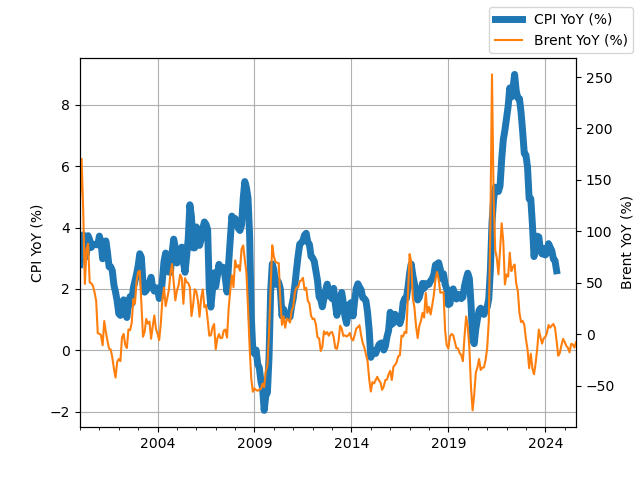

In [22]:
# plot and set labels of the figure
START_YEAR = '2000'
fig, ax = plt.subplots()
cpiausl_yoy.loc[START_YEAR:].plot(ax=ax, linewidth=5);
ax2 = brent_extended_yoy.loc[START_YEAR:].plot(secondary_y=True, ax=ax);
ax.grid(True);
ax.set_ylabel('CPI YoY (%)');
ax2.set_ylabel('Brent YoY (%)');
ax.figure.legend(['CPI YoY (%)','Brent YoY (%)']);

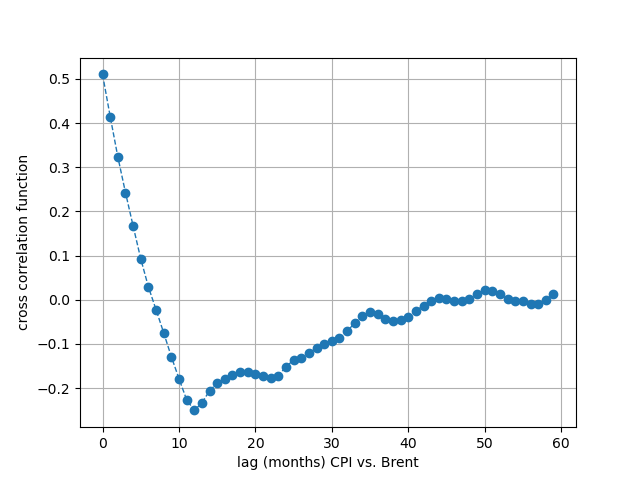

In [23]:
# now let's try to cross-correlate these 2 indicators to see the lags at which there is some correlation 
# and how big that is. To do so, we only look at the real data available, not the extended brent series.
import statsmodels.tsa.stattools as smtsast
common_dates = brent_yoy.loc[~brent_yoy.isna()].index.intersection(cpiausl_yoy.index)
cc = smtsast.ccf(brent_yoy.loc[common_dates], cpiausl_yoy.loc[common_dates])
cross_correl_function = pd.Series(cc[:60])
fig, ax = plt.subplots()
cross_correl_function.plot(ax=ax, linewidth=1, style='o--');
ax.grid(True);
ax.set_xlabel('lag (months) CPI vs. Brent');
ax.set_ylabel('cross correlation function');

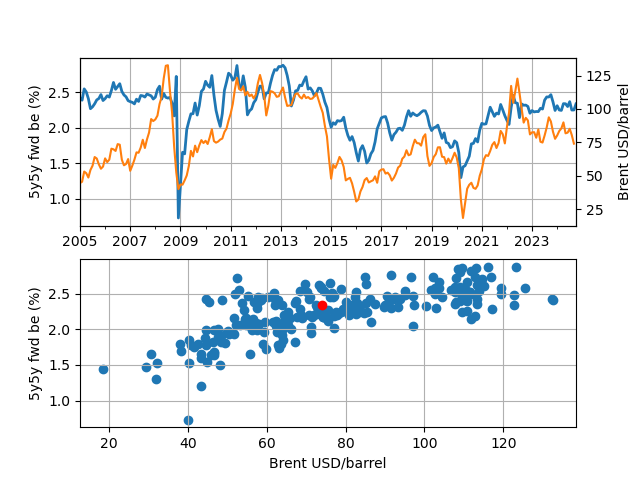

In [24]:
# let's also plot the history of the brent vs. the inflation rate and create a regression analysis with the latest value highlighted in a different colour
# the paper suggests to do this from 2005 (or after the great recession) onwards
START_YEAR = '2005'
fig, ax = plt.subplots(2,1)
ax1 = be5y5y.loc[START_YEAR:].plot(ax=ax[0], linewidth=2);
ax2 = brent.loc[START_YEAR:].plot(secondary_y=True, ax=ax[0]);
ax[0].grid(True);
ax1.set_ylabel('5y5y fwd be (%)');
ax2.set_ylabel('Brent USD/barrel');
plt.sca(ax[1])
tmp = brent.loc[START_YEAR:]
plt.scatter(tmp, be5y5y.loc[tmp.index]);
plt.scatter(tmp.iloc[-1], be5y5y.iloc[-1], color='r')
ax[1].grid(True);
ax[1].set_ylabel('5y5y fwd be (%)');
ax[1].set_xlabel('Brent USD/barrel');